# Neighbor-Joining Algorithm

In [1]:
DNA_sim = {'G': { 'G':1, 'C':0, 'A':0, 'T':0 },
         'C': { 'G':0, 'C':1, 'A':0, 'T':0 },
         'A': { 'G':0, 'C':0, 'A':1, 'T':0 },
         'T': { 'G':0, 'C':0, 'A':0, 'T':1 }}

DNA_sim2 = {'G': { 'G': 1, 'C':-3, 'A':-2, 'T':-2},
         'C': { 'G':-2, 'C': 1, 'A':-2, 'T':-2},
         'A': { 'G':-2, 'C':-2, 'A': 1, 'T':-2},
         'T': { 'G':-2, 'C':-2, 'A':-2, 'T': 1}}  

seq1 = ['CAGCCGCACACAGACCCTGAG',
            'CAGCTGCCCGCAGACCCTGAG',
            'CGGCTGCACGCAGACCCTGAG',
            'CAGCTGCATGTGGACCCTGAG',
            'CGGGTGCACGTGGACCCTGAG',
            'TGGCTGCACGTGGACCCTGAG',
            'AAGCTGCATGTGGACCCTGAG']

This function calculates the similarity between two sequences given the penalties listed in the similarity matrix sim_mat.

In [2]:
def seq_sim(s1, s2, sim_mat):
    
  # needed if one sequence is longer than the other  
  num_bases = min(len(s1), len(s2))
  
  seq_score = float(0)
  
  for i in range(num_bases):
    
    bases1 = s1[i]
    bases2 = s2[i]
  
    seq_score += sim_mat[bases1][bases2]

  return seq_score

This function aligns any two sequences.

In [3]:
def seq_align(s1, s2, sim_mat=DNA_sim2):

  num_s1 = len(s1) + 1
  num_s2 = len(s2) + 1

  smat = [[0] * num_s2 for x in range(num_s1)]

  for i in range(1, num_s1):
    for j in range(1, num_s2):
        
      sim = sim_mat[ s1[i-1] ][ s2[j-1] ]
      
      posib = [smat[i-1][j-1] + sim]                   
      
      lgst = max(posib)
      smat[i][j] = lgst
      
  align_s1 = []
  align_s2 = []
  
  i = num_s1-1
  j = num_s2-1
  score = smat[i][j]
  
  align_s1.reverse()
  align_s2.reverse()
  align_s1 = ''.join(align_s1)
  align_s2 = ''.join(align_s2)

  return score, align_s1, align_s2 


This function calculates the distance matrix for given sequence data.

In [4]:
def calc_dist_mat(seq_data, sim_mat):

  n = len(seq_data)
  matrix = [[0] * n for i in range(n)]
  max_vals = [seq_sim(i, i, sim_mat) for i in seq_data]

  for i in range(n-1):
    s1 = seq_data[i]
  
    for j in range(i+1,n):
      s2 = seq_data[j]
      
      val, align_s1, align_s2 = seq_align(s1, s2, sim_mat)
      max_val = max(max_vals[i],max_vals[j])
      dist = max_val - val;
      
      matrix[i][j] = dist
      matrix[j][i] = dist

  return matrix

This function uses the distance matrix to determine which pairs of sequences should be joined.

In [5]:
def njPair(dist_mat):
    n = len(dist_mat)
    
    minM = None
    nj_Pair = None
    
    # sum of rows of dist_mat; range(n-1) because indexed at 0
    for i in range(n-1):
        Rn = sum(dist_mat[i])
        
        # sum of columns/following row of dist_mat
        for j in range(i+1, n):
            Rm = sum(dist_mat[j])
            
            # dnm is exactly as in formula
            dnm = dist_mat[i][j]
            Mnm = (n-2)*dnm - Rn - Rm
            
            # assigns lowest Mnm value to a node
            if (minM is None) or (Mnm < minM):
                minM = Mnm
                nj_Pair = [i, j]
    return nj_Pair

This function determines the distance of each sequence to the node formed by the first two sequences paired.

In [6]:
def distToNode(dist_mat, i, j):
  
  n = len(dist_mat)
  Rn = sum(dist_mat[i]) # sum of rows
  Rm = sum(dist_mat[j]) # sum of columns
    
  dnm = dist_mat[i][j] # value in distance matrix at i,j or n,m
 
  dist = dnm + (Rn-Rm)/(n-2)
  dist *= 0.5 # multiply the equation directly above by 1/2

  return dist

This function enacts the neighbor-joining algorithm given the distance matrix of a dataset of sequences.

In [7]:
def njTree(dist_mat):
 
  node_ord = []
  n = len(dist_mat)
  tree = list(range(n))
  
  while n > 2:
    
    # x, y are the closest pair and should be joined during this first round
    x, y = njPair(dist_mat)

    # node corresponds to positions x and y in distance matrix and tree list
    node = (tree[x], tree[y])
    
    # new branch node added to node_ord list and tree list
    node_ord.append(node)
    tree.append(node)
    
    # must delete y element first since largest list index must be deleted first
    # otherwise, deleting smaller index x will shuffle rest of list by one
    del tree[y]
    del tree[x]
    
    
    # calculate distance from joined x, y positions to new node
    distX = distToNode(dist_mat, x, y)
    distY = distToNode(dist_mat, y, x)
  
    dist_mat.append([0] * (n+1))

    # loop through all positions in the distance matrix, except newly added one
    for i in range(n):
      if i not in (x,y):

        dist = (dist_mat[x][i]-distX) + (dist_mat[y][i]-distY)
        dist *= 0.5
  
        # fill in new distance values for ends of row/column i
        dist_mat[i].append(dist)
        dist_mat[n][i] = dist

    # delete old x and y positions from matrix
    del dist_mat[y]
    del dist_mat[x]
    
    # delete two rows and then loop through rest of rows and delete corresponding two cols
    for row in dist_mat:
      del row[y]
      del row[x]

    # decrease n by one, since after merging, distance matrix one row/column smaller
    n -= 1

  # convert tree list to tuple to allow Newick notation output
  tree = tuple(tree)
  node_ord.append(tree)
  
  return tree, node_ord


In [8]:
dist_mat = calc_dist_mat(seq1, DNA_sim)

In [9]:
for row in dist_mat:
    print(['%.1f' % x for x in row])
    
print("\nWhich is the closest sequence pair in the sequence data?")

print(njPair(dist_mat))

dist_mat = calc_dist_mat(seq1, DNA_sim)
tree, node_ord = njTree(dist_mat)

['0.0', '3.0', '3.0', '5.0', '6.0', '6.0', '6.0']
['3.0', '0.0', '2.0', '4.0', '5.0', '5.0', '5.0']
['3.0', '2.0', '0.0', '4.0', '3.0', '3.0', '5.0']
['5.0', '4.0', '4.0', '0.0', '3.0', '3.0', '1.0']
['6.0', '5.0', '3.0', '3.0', '0.0', '2.0', '4.0']
['6.0', '5.0', '3.0', '3.0', '2.0', '0.0', '3.0']
['6.0', '5.0', '5.0', '1.0', '4.0', '3.0', '0.0']

Which is the closest sequence pair in the sequence data?
[3, 6]


In [10]:
treedata = tree
print(treedata)

((4, 5), ((3, 6), (2, (0, 1))))


        _____ 4
  _____|
 |     |_____ 5
 |
_|            _____ 3
 |      _____|
 |     |     |_____ 6
 |_____|
       |      _____ 2
       |_____|
             |      ______ 0
             |_____|
                   |______ 1



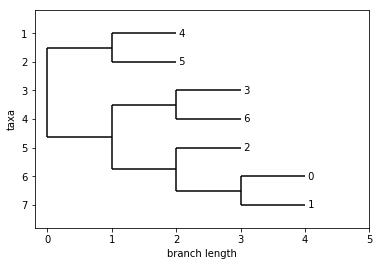

In [11]:
from Bio import Phylo as phy

'''
A lot of BioPython's functions only take file-like objects, 
StringIO just creates a memory buffer that lets a string pretend 
to be a file (technically a string buffer)
'''
from io import StringIO

# create string buffer from Newick string
tree_str = StringIO(str(treedata))
# read tree into a Phylo tree object
tree = phy.read(tree_str, 'newick')

'''
Prints ASCII tree to standard output (probably the console unless 
your setup is weird). If you want it saved to a file either pipe 
the output to a file in terminal or use sys.out (look it up)
'''
phy.draw_ascii(tree, column_width=30)

# if you're too cool for ASCII art (or just born after 1995), Phylo can also draw trees in matplotlib
phy.draw(tree)

To add noise, we added random point mutations in a larger dataset.

In [12]:
seq2 = ['CAGCCGCACACAGATCCTGAG',
       'CAGCTGCACGCAGATCCTGAG',
       'CGGCTGCACGCAGATCCTGAG',
       'CAGCTGCACGTGGATCCTGAG',
       'CGGCTGCACGTCGATCCTGAG',
       'CGGCTGCACGTGGATCCTGAG',
       'CAGCTGCATGTGGACCCTGAG', 
       'CAGCTGCATGTGGACCCAGAG', 
       'AGGCTCCATGTGGACCCAGAT'
       'CAGCTGCACGCAGATTTCAAG',
       'CGGCTGCACGCAGATTTCGAG',
       'CAGCTGCACGTGGATTTCGAG',
       'CGGCTGCACTAGGATCCTGAG'
       'CAGCTGCACGCAGATCCTCAG',
       'AGCCTGCTCGCAGATCCTGAG',
       'CAGCTGCACGTGGATCCTGAG',
       'CGCCTGCACGTTGATGCAGAG']

In [13]:
dist_mat2 = calc_dist_mat(seq2, DNA_sim)

In [14]:
for row in dist_mat2:
    print(['%.1f' % x for x in row])

print("\nWhich is the closest sequence pair in the sequence data?")

print(njPair(dist_mat2))
tree2, node_ord = njTree(dist_mat2)

['0.0', '2.0', '3.0', '4.0', '5.0', '5.0', '6.0', '7.0', '27.0', '6.0', '7.0', '24.0', '6.0', '4.0', '8.0']
['2.0', '0.0', '1.0', '2.0', '3.0', '3.0', '4.0', '5.0', '25.0', '4.0', '5.0', '22.0', '4.0', '2.0', '6.0']
['3.0', '1.0', '0.0', '3.0', '2.0', '2.0', '5.0', '6.0', '26.0', '3.0', '6.0', '23.0', '3.0', '3.0', '5.0']
['4.0', '2.0', '3.0', '0.0', '2.0', '1.0', '2.0', '3.0', '27.0', '6.0', '3.0', '24.0', '6.0', '0.0', '5.0']
['5.0', '3.0', '2.0', '2.0', '0.0', '1.0', '4.0', '5.0', '28.0', '5.0', '5.0', '25.0', '5.0', '2.0', '4.0']
['5.0', '3.0', '2.0', '1.0', '1.0', '0.0', '3.0', '4.0', '28.0', '5.0', '4.0', '25.0', '5.0', '1.0', '4.0']
['6.0', '4.0', '5.0', '2.0', '4.0', '3.0', '0.0', '1.0', '29.0', '8.0', '5.0', '26.0', '8.0', '2.0', '7.0']
['7.0', '5.0', '6.0', '3.0', '5.0', '4.0', '1.0', '0.0', '29.0', '8.0', '5.0', '27.0', '9.0', '3.0', '6.0']
['27.0', '25.0', '26.0', '27.0', '28.0', '28.0', '29.0', '29.0', '0.0', '23.0', '24.0', '12.0', '29.0', '27.0', '29.0']
['6.0', '4.0', '

In [15]:
treedata2 = tree2
print(treedata2)

((4, (5, ((6, 7), (3, 13)))), (14, (((8, 11), (9, 10)), ((0, 1), (2, 12)))))


      ____ 4
     |
  ___|     ___ 5
 |   |    |
 |   |____|         ____ 6
 |        |    ____|
 |        |   |    |____ 7
 |        |___|
 |            |     ____ 3
_|            |____|
 |                 |____ 13
 |
 |    ____ 14
 |   |
 |   |              ____ 8
 |   |         ____|
 |___|        |    |____ 11
     |     ___|
     |    |   |     ____ 9
     |    |   |____|
     |    |        |____ 10
     |____|
          |         ____ 0
          |    ____|
          |   |    |____ 1
          |___|
              |     ____ 2
              |____|
                   |____ 12



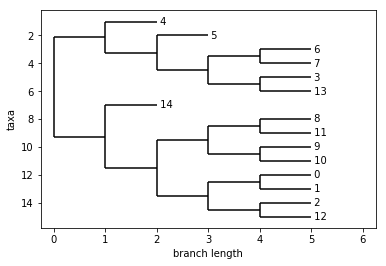

In [16]:
# create string buffer from Newick string
tree_str = StringIO(str(treedata2))
# read tree into a Phylo tree object
tree = phy.read(tree_str, 'newick')

'''
Prints ASCII tree to standard output (probably the console unless 
your setup is weird). If you want it saved to a file either pipe 
the output to a file in terminal or use sys.out (look it up)
'''
phy.draw_ascii(tree, column_width=30)

# if you're too cool for ASCII art (or just born after 1995), Phylo can also draw trees in matplotlib
phy.draw(tree)